# Introduction to the Monte Carlo method

Start by defining the Gibbs distribution:
$$P(\alpha) = e^{-E(\alpha)/kT}$$
this expression, defines the probability of observing a particular configuration of spins, $\alpha$. 
As you can see, the probability of $\alpha$ decays exponentially with increasing energy of $\alpha$, $E(\alpha)$,
where $k$ is the Boltzmann constant, $k = 1.38064852 \times 10^{-23} J/K$
and $T$ is the temperature in Kelvin. 

## What defines the energy of a configuration of spins? 
Given a configuration of spins (e.g., $\uparrow\downarrow\downarrow\uparrow\downarrow$) we can define the energy using what is referred to as an Ising Hamiltonian:
$$ \hat{H}' = \frac{\hat{H}}{k} = \frac{J}{k}\sum_{<ij>} s_is_j,$$
where, $s_i=1$ if the $i^{th}$ spin is `up` and $s_i=-1$ if it is `down`, and the brackets $<ij>$ indicate a sum over spins that are connected,
and $J$ is a constant that determines the energy scale. 
The energy here has been divided by the Boltzmann constant to yield units of temperature. 
Let's consider the following case, which has the sites connected in a single 1D line:
$$\alpha = \uparrow-\downarrow-\downarrow-\uparrow-\downarrow.$$ 
What is the energy of such a configuration?
$$ E(\alpha)' = J/k(-1 + 1 - 1 - 1) = \frac{E(\alpha)}{k} = -2J/k$$

## Properties
For any fixed state, $\alpha$, the `magnetization` ($M$) is proportional to the _excess_ number of spins pointing up or down while the energy is given by the
Hamiltonian:
$$M(\alpha) = N_{\text{up}}(\alpha) - N_{\text{down}}(\alpha).$$
As a dynamical, fluctuating system, each time you measure the magnetization, the system might be in a different state ($\alpha$) and so you'll get a different number!
However, we already know what the probability of measuring any particular $\alpha$ is, so in order to compute the average magnetization, $\left<M\right>$, we just need to multiply the magnetization of each possible configuration times the probability of it being measured, and then add them all up!
$$ \left<M\right> = \sum_\alpha M(\alpha)P(\alpha).$$
In fact, any average value can be obtained by adding up the value of an individual configuration multiplied by it's probability:
$$ \left<E\right> = \sum_\alpha E(\alpha)P(\alpha).$$

This means that to obtain any average value (also known as an `expectation value`) computationally, we must compute the both the value and probability of all possible configurations. This becomes extremely expensive as the number of spins ($N$) increases. 

In [1]:
from numba import jit

import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import montecarlo
import random

# boltzmann constant, k = 1.38064852 × 10-23 m^2 kg s-2 K-1
N = 8


conf = montecarlo.SpinConfig1D(N=N)
conf.initialize(M=2)
ham = montecarlo.IsingHamiltonian1D(-1.0, 1.01)

Ei = ham.expectation_value(conf)
Pi = np.e**(-Ei)
print(" Energy of      ", conf.config, " is ", Ei)
print(" Probability of ", conf.config, " is ", Pi)


 Initialized config to:  [1 0 0 0 0 0 1 0]
 Energy of       [1 0 0 0 0 0 1 0]  is  4.04
 Probability of  [1 0 0 0 0 0 1 0]  is  0.017597472415623396


# Question 1
How many configurations are possible for:

(a) N=10?

(b) N=100?

(c) N=1000?

# Sampling
These calculation pose a drastic problem from a practical perspective. 
 As $N$ becomes large it is evident that
computations become a daunting task if calculated in this manner.
 Thus a better numerical alternative would be to use a simulation to generate data over
the ‘representative states’. 
Because each computed value of a configuration gets weighted by it's probability, very high energy states (which have negligible probabilities due to the Boltzmann distribution) will not contribute to the overall sum.  
This is a form of biased sampling which
essentially boils down to satisfying the following condition where
`generated frequency` = `actual probability`.

An expectation value of any quantity, $A$, computed (using the Canonical Ensemble) can also be defined as:
$$\left<A\right> = \frac{1}{Z}\int e^{-E(\alpha)/T}A(\alpha)d\alpha,$$
where $Z$ is referred to as the `partition function`, and is essentially a normalization constant:
$$ Z = \int e^{-E(\alpha)/T}d\alpha,$$ and
$$ P(\alpha) = \frac{1}{Z}e^{-E(\alpha)/T}.$$
This probability gives the actual statistical weight with which the configuration
$\alpha$ occurs in the thermal equilibrium. We now want to consider the discrete case
of the formal definitions above. If we are to consider a finite portion of the
configuration space it would produces an average of the form:
$$
\left<A\right> = \frac{\displaystyle\sum_\alpha e^{-E'(\alpha)/T}A(\alpha)}{\displaystyle\sum_\alpha e^{-E'(\alpha)/T}}$$

We could choose to randomly `sample` from this full set of configurations, but this will not converge quickly. 

In [2]:
import numpy as np
import matplotlib as mpl
from random import sample
import copy as cp

# boltzmann constant, k = 1.38064852 × 10-23 m^2 kg s-2 K-1
energies = np.linspace(0, 10, 100);

print(conf)
conf.set_rand_config()

print(conf)

10000010
00101110


----
# Energy/Magnetization vs Temperature (exact)

 Number of configurations:  256
 Critical Temperature:   0.90000000 
     E:   -7.63283349
     M:    4.85549011
     EE:   4.58941716
     MM:  34.03986342
 Critical Temperature:   1.00000000
 E =  -3.88449265 @ T =   2.00000000


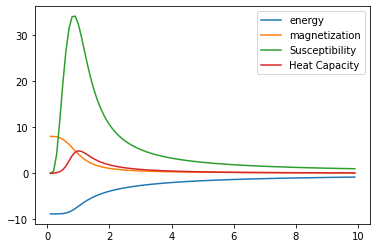

In [3]:
print(" Number of configurations: ", conf.n_dim)
n_samples = 100

e_list = []
e2_list = []
m_list = []
m2_list = []
T_list = []

ham.J = 1.0
ham.mu = 0.1
for Ti in range(1,100):
    T = .1*Ti
    # print(T)
    E = 0.0
    M = 0.0
    Z = 0.0
    EE = 0.0
    MM = 0.0

    T_list.append(T)
    
    # for i in range(n_samples):
    for i in range(conf.n_dim):
        # conf.set_rand_config()
        conf.set_int_config(i)
        Ei = ham.expectation_value(conf)
        Zi = np.exp(-Ei/T)
        E += Ei*Zi
        EE += Ei*Ei*Zi
        Mi = np.sum(2*conf.config-1)
        M += Mi*Zi
        MM += Mi*Mi*Zi
        Z += Zi
        
    e_list.append(E/Z)
    m_list.append(M/Z)
    e2_list.append((EE/Z-E/Z*E/Z)/(T*T))
    m2_list.append((MM/Z-M/Z*M/Z)/T)
    # print(" Sum Energy = %12.8f" %(E))
    # print(" Sum Norm   = %12.8f" %(Z))
    # print(" Average Energy = %12.8f" %(E/Z))
plt.plot(T_list, e_list, label="energy");
plt.plot(T_list, m_list, label="magnetization");
plt.plot(T_list, m2_list, label="Susceptibility");
plt.plot(T_list, e2_list, label="Heat Capacity");
plt.legend();

Tc_ind = np.argmax(m2_list)
print(" Critical Temperature: %12.8f " %(T_list[Tc_ind]))
print("     E:  %12.8f" %(e_list[Tc_ind]))
print("     M:  %12.8f" %(m_list[Tc_ind]))
print("     EE: %12.8f" %(e2_list[Tc_ind]))
print("     MM: %12.8f" %(m2_list[Tc_ind]))
Tc2 = T_list[np.argmax(e2_list)]
print(" Critical Temperature: %12.8f" %(Tc2))

print(" E = %12.8f @ T = %12.8f"% (e_list[T_list.index(2.00)], 2.0))

----
# Energy/Magnetization vs Temperature (Metropolis Sampling)

In [4]:
n_samples = 10000
T = .9
Z = 0.0
E = 0.0
# Mavg = np.zeros(n_samples)
# Eseries = np.zeros(n_samples)

Ei = ham.expectation_value(conf)

def sweep(conf, T, ham):
    for site_i in range(conf.N):
        
        # new_conf, delta_e = ham.delta_e_for_flip(site_i, conf)      
        delta_e = 0.0
        
        # assume PBC
        iright = (site_i+1)%conf.N
        ileft  = (site_i-1)%conf.N
        if conf.config[ileft] == conf.config[iright]:
            if conf.config[ileft] == conf.config[site_i]:
                delta_e = 4.0*ham.J
            else:
                delta_e = -4.0*ham.J
                
        delta_e += 2*ham.mu * (2*conf.config[site_i]-1)


        # prob_trans = 1.0 # probability of transitioning
        accept = True
        if delta_e > 0:
            # prob_trans = np.exp(-delta_e/T)
            if random.random() > np.exp(-delta_e/T):
                accept = False
        if accept:
            if conf.config[site_i] == 0:
                conf.config[site_i] = 1
            else:
                conf.config[site_i] = 0
            # conf.flip_site(i)



def compute_montecarlo(ham, conf, T, n_samples, nburn, plot=True):
    Eseries = []
    Eavg = 0.0

    for si in range(n_samples):
        sweep(conf, T, ham)
        Ei = ham.expectation_value(conf)
        if si > nburn:    
            Eseries.append(Ei)
        

    Eavg = np.zeros(len(Eseries))
    Estd = np.zeros(len(Eseries))
    Eavg[0] = Eseries[0]
    for i in range(1,len(Eseries)):
        Eavg[i] = np.mean(Eseries[0:i])
        Estd[i] = np.std(Eavg[0:i])
    

    if plot:
        plt.plot(Eseries, label="Energy")
        plt.plot(Eavg, label="avg(E)")
        # plt.plot(Estd, label="std(E)")
        plt.legend()

    print(" <E> = %12.8f " %np.mean(Eseries))

    return np.mean(Eseries)


 Initialized config to:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 <E> =  -9.17428714 
 Initialized config to:  [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 <E> =  -9.20720360 
 Initialized config to:  [0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 <E> =  -9.16748374 
 Initialized config to:  [0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 <E> =  -9.20290145 
 Initialized config to:  [0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0]
 <E> =  -9.16378189 
 Initialized config to:  [0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0]
 <E> =  -9.19419710 
 Initialized config to:  [0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0]
 <E> =  -9.20230115 
 Initialized config to:  [0 1 1 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 1 0]
 <E> =  -9.19419710 
 Initialized config to:  [0 1 1 0 0 1 0 0 0 0 1 1 1 0 0 0 1 0 1 0]
 <E> =  -9.24852426 
 Initialized config to:  [0 1 1 0 1 1 0 0 0 0 1 1 1 0 0 0 1 0 1 0]
 <E> =  -9.21230615 
 Initialized config to:  [0 1 1 0 1 1 0 0 0 0 1 1 1 0 1 0 1 0 1 0]
 <E> =  -9.16958479 
 Initialized config to:  [0 1 1 

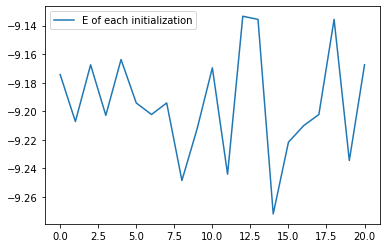

In [30]:
# Now run the simulation
N = 20

E = []
for i in range(N+1):
    conf = montecarlo.SpinConfig1D(N=N)
    conf.initialize(M=i)
    Ei = compute_montecarlo(ham, conf, 2, 10000, 8000, plot=False)
    E.append(Ei)

print()
print(" STD of initializations: %12.8f" % np.std(E))
print(" AVG of initializations: %12.8f" % np.mean(E))
plt.plot(E, label="E of each initialization");
plt.legend();

 Initialized config to:  [0 0 0 0 0 0 0 0]
 <E> =  -3.86175735 


-3.861757352606937

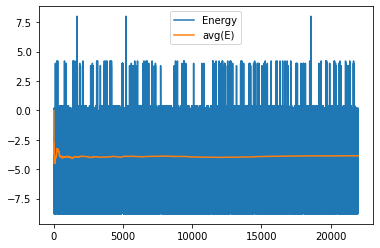

In [24]:
# prun compute_montecarlo(ham, conf, 2, 20000, 5000, plot=False)
conf = montecarlo.SpinConfig1D(N=N)
conf.initialize(M=0)
compute_montecarlo(ham, conf, 2, 30000, 8000, plot=True)

 Initialized config to:  [0 1 1 0 1 1 0 0 0 0 1 1 1 0 1 0 1 0 1 0]
 <E> = -21.93928482 
 Initialized config to:  [0 1 1 0 1 1 0 0 0 0 1 1 1 0 1 0 1 0 1 0]
 <E> = -17.60965241 
 Initialized config to:  [0 1 1 0 1 1 0 0 0 0 1 1 1 0 1 0 1 0 1 0]
 <E> = -12.44696174 
 Initialized config to:  [0 1 1 0 1 1 0 0 0 0 1 1 1 0 1 0 1 0 1 0]
 <E> =  -9.45821455 
 Initialized config to:  [0 1 1 0 1 1 0 0 0 0 1 1 1 0 1 0 1 0 1 0]
 <E> =  -8.13933483 
 Initialized config to:  [0 1 1 0 1 1 0 0 0 0 1 1 1 0 1 0 1 0 1 0]
 <E> =  -6.42445611 
 Initialized config to:  [0 1 1 0 1 1 0 0 0 0 1 1 1 0 1 0 1 0 1 0]
 <E> =  -5.46376594 
 Initialized config to:  [0 1 1 0 1 1 0 0 0 0 1 1 1 0 1 0 1 0 1 0]
 <E> =  -4.58194549 
 Initialized config to:  [0 1 1 0 1 1 0 0 0 0 1 1 1 0 1 0 1 0 1 0]
 <E> =  -4.76739185 


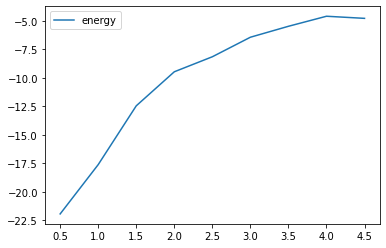

In [35]:
Tpoints = 10
e_list = []
T_list = []
for Ti in range(1,10):
    T = .5*Ti
    conf = montecarlo.SpinConfig1D(N=N)
    conf.initialize(M=int(N/2))
    E = compute_montecarlo(ham, conf, T, 10000, 6000, plot=False)
    
    e_list.append(E)
    T_list.append(T)

plt.plot(T_list, e_list, label="energy");
# plt.plot(T_list, m_list, label="magnetization");
# plt.plot(T_list, m2_list, label="Susceptibility");
# plt.plot(T_list, e2_list, label="Heat Capacity");
plt.legend();

# Tc_ind = np.argmax(m2_list)
# print(" Critical Temperature: %12.8f " %(T_list[Tc_ind]))
# print("     E:  %12.8f" %(e_list[Tc_ind]))
# print("     M:  %12.8f" %(m_list[Tc_ind]))
# print("     EE: %12.8f" %(e2_list[Tc_ind]))
# print("     MM: %12.8f" %(m2_list[Tc_ind]))
# Tc2 = T_list[np.argmax(e2_list)]
# print(" Critical Temperature: %12.8f" %(Tc2))

Metropolis referenced from: [here](https://arxiv.org/pdf/0803.0217.pdf)
